# tutorial4.ipynb

A simple closed-loop simulation.

This tutorial illustrates a very simple example of synaptic learning being used to improve the control of a mechanical system.

The mechanical system is a pendulum with no perturbations, and the control task is to rotate it so it stably reaches a desired angle. The pendulum is implemented with the `plants.pendulum` class.

The control system consists of six units. Four sigmoidal "afferent units" relay the pendulum's state to a linear "control" unit whose output produces a torque on the pendulum's joint. The sixth unit is an "error" unit, providing an error signal to the control unit. This signal consists of the angle of the rotation required to go from the pendulum's current angle to the desired angle. Usually the error signal would be  $(\theta_{des} - \theta_p)$, where $\theta_{des}$ is the desired angle, and $\theta_p$ is the current pendulum's angle. Instead, due to the periodicity of the angles (they range from 0 to $2\pi$) the actual error signal is
$ \left[ (\theta_{des} - \theta_p + \pi) \mod 2\pi \right] - \pi$, where 'mod' is the modulus operation. This error is provided by a function called `ang_dev` in the code below.

The pendulum is a two-dimensional dynamical system, but we need four afferent units to represent its state. As described in the `plants.pendulum` class documentation, the pendulum has two state variables: angle and angular velocity. Those variables can adopt negative values, but we assume that the sigmoidal units that represent them only have positive outputs. To properly represent the pendulum outputs we use a sigmoidal unit that grows when it becomes more positive, and one that grows when it becomes more negative. This is achieved by changing the sign of the synapses at the connections from the pendulum to the sigmoidal units. 

In the first simulation we effectively remove the inputs coming from the four afferent units. The system thus consists of the pendulum providing its current angle to the error unit, the error unit providing an input to the control unit, and the control unit exerting a torque on the pendulum. This effectively turns the two units into a proportional controller. Roughly, when $\theta_{des} > \theta_p$ the control unit provides a positive torque, and viceversa. As would be expected this is not a very good controller, and oscillations ensue.

In the second simulation the four afferent units are connected to the control unit, and synaptic learning is used on those connections in order to improve the performance of the controller. But how to learn synaptic weights that will create a better controller? To this end we use the *input correlation* learning rule, as described in http://www.mitpressjournals.org/doi/abs/10.1162/neco.2006.18.6.1380#.WPhOL0clE58, and implemented in the `synapses.input_correlation_synapse` class. Because our control unit uses the input correlation rule, in the code below it is called `ic`.

The input correlation rule is defined by the following equation:   
$\frac{d\omega_j}{dt} = \mu u_j \frac{du_0}{dt}$,   
where $\omega_j$ is the synaptic weight from the $j$-th input, $u_j$ is the $j$-th input, and $\mu$ is a constant learning rate. In here $u_0$ is a special input that conveys an error, as in the proportional controller. What the controller tries to achieve is to make $u_0=0$. The other inputs convey sensory information that can be used to predict when the error will increase, e.g. when will $\frac{du_0}{dt} > 0$. Let's see how this rule makes sense intuitively.

Suppose that input $u_1$ correlates with increases of the error. This means that large values of $u_1$ and positive values of $\frac{du_0}{dt}$ tend to happen together. There are two implications from this: 
1. $u_1$ is predictive of larger values of $u_0$. 
2. $\omega_1$ will grow larger.

The result is that inputs predicting large error values will anticipatively increase the amplitude of the control signal, preventing the error that they predict. In the second simulation we'll see that this can be effective.

There are many details left out in this exposition, since the purpose of this tutorial is just to illustrate how to connect units and plants in draculab. Readers who want to learn more about the input correlation rule should consult the paper linked above: 

Porr & Worgotter (2006) Strongly improved stability and faster convergence of temporal sequence learning by using input correlations only, *Neural computation* **18**, 1380-1412.

In [1]:
%cd ..
from draculab import *
from matplotlib import pyplot as plt
import time

/home/z/projects/draculab


In [8]:
class ic_control():
    def __init__(self):
    ########### Create parameter dictionaries for network, plant, and units
        # parameter dictionary for the network
        self.net_params = {'min_delay' : 0.01, 
                           'min_buff_size' : 4, 
                           'rtol' : 1e-5, 
                           'atol' : 1e-5 } 
        # This pendulum has no gravity (horizontal pendulum). Initial position is 45 degrees.
        self.plant_params = {'type' : plant_models.pendulum, 
                             'length' : 2.,      # length in meters
                             'inp_gain' : 10.,   # input gain
                             'g' : 0.,           # gravitation constant
                             'mass' : 10.,       # in kilograms
                             'mu' : 1.,          # viscous friction coefficient
                             'init_angle' : np.pi/2., # initial angle in radians
                             'init_ang_vel' : -0.2}   # initial angular velocity
        # parameter dictionary for the afferent input units
        self.aff_unit_pars = {'init_val' : 0.5,
                              'type' : unit_types.sigmoidal,
                              'tau_fast' : 0.01,
                              'slope' : [0.5, 0.5, 0.2, 0.2],
                              'thresh' : [0.2, 0.2, 0.2, 0.2],
                              'tau' : 0.02} 
        # parameter dictionary for the "controller" unit using input correlation
        self.ic_unit_pars = {'init_val' : 0.5,
                             'type' : unit_types.linear,
                             'tau' : 0.02}
        # parameter dictionary for the source unit providing the error signal to the ic unit
        self.err_unit_pars = {'init_val' : 0.,
                              'tau_fast' : 0.01,
                              'tau_mid' : 0.1, 
                              'function' : lambda x:None,
                              'type' : unit_types.source}
    ########### Create parameter dictionaries for the synapses and connections
        self.pend2affs_syn_spec = {'init_w' : [1., -1., 1., -1.], 'type' : synapse_types.static}
        self.ic2pend_syn_spec = {'init_w' : 1., 'type' : synapse_types.static}
        self.affs2ic_syn_spec = {'init_w' : 0., 'lrate' : 15., 'input_type' : 'pred', 'type' : synapse_types.inp_corr}
        self.err2ic_syn_spec = {'init_w' : 2., 'lrate' : 0.1, 'input_type' : 'error', 'type' : synapse_types.inp_corr}

        # port map: first two units receive angle, second two receive angular velocity
        self.pend2affs_conn_spec = { 'port_map' : [ [(0,0)], [(0,0)], [(1,0)], [(1,0)] ], 'delays' : 0.01}
        self.ic2pend_conn_spec = {'inp_ports' : [0], 'delays' : 0.02}
        self.affs2ic_conn_spec = {'rule' : 'all_to_all', 'delay' : 0.02}
        self.err2ic_conn_spec = {'rule' : 'all_to_all', 'delay' : 0.02}
        
    def sq_ang_dev(self, t): # a squared error, has no direction information
        pend_ang = self.net.plants[self.pend].get_angle(t) # angle modulo 2pi
        ang_diff = self.des_ang - pend_ang
        # There are two angle differences, depending on the 'direction' we measure. We want the smallest.
        return ( (ang_diff + np.pi) % (2*np.pi) - np.pi )**2
    
    def ang_dev(self, t): # using this as the error, the ic effectively turns into a proportional controller
        pend_ang = self.net.plants[self.pend].get_angle(t) # angle modulo 2pi
        # Smallest rotation required to go from pend_ang to des_ang:
        return (self.des_ang - pend_ang + np.pi) % (2*np.pi) - np.pi
        
    def initialize(self):
    ########### Create network, plant, and input units
        self.net = network(self.net_params)  # creating a network
        self.pend = self.net.create(1, self.plant_params) # a pendulum
        self.affs = self.net.create(4, self.aff_unit_pars) # afferent units
        self.ic = self.net.create(1, self.ic_unit_pars) # controller unit
        self.err = self.net.create(1, self.err_unit_pars) # error unit

    ########### Set the error function
        self.des_ang = 0. # desired angle in range [0,2*pi)
        self.net.units[self.err[0]].set_function( self.ang_dev )

    ########### Connect
        # afferents to controller
        self.net.connect(self.affs, self.ic, self.affs2ic_conn_spec, self.affs2ic_syn_spec)
        # error to controller
        self.net.connect(self.err, self.ic, self.err2ic_conn_spec, self.err2ic_syn_spec)  
        # controller to plant
        self.net.set_plant_inputs(self.ic, self.pend, self.ic2pend_conn_spec, self.ic2pend_syn_spec)
        # plant to afferents
        self.net.set_plant_outputs(self.pend, self.affs, self.pend2affs_conn_spec, self.pend2affs_syn_spec)  

    ########## To keep track of error 'derivative', use an isolated source unit
        track_unit_pars = {'init_val' : 0., 'function' : lambda x:None, 'type' : unit_types.source}
        self.track = self.net.create(1, track_unit_pars)
        self.net.units[self.track[0]].set_function( lambda x : self.net.units[self.ic[0]].err_diff )

    def simulate(self, sim_time, flat=True):
    ########### Simulate
        start_time = time.time()
        if flat:
            self.times, self.unit_stor, self.plant_stor = self.net.flat_run(sim_time)
        else:
            self.times, self.unit_stor, self.plant_stor = self.net.run(sim_time)
        print('Execution time: %s seconds' % (time.time() - start_time))

    def plot_results(self):
        # Plot the state variables of the pendulum
        lw = 4 # linewidth
        ls = 30 # label size
        fig = plt.figure(figsize=(18,17))
        ax0a = fig.add_axes([0.01, .84, .99, 0.16 ])
        ax0a.set_ylabel('angle (rad)', fontsize='xx-large')
        ax0a.tick_params(labelsize=ls)
        ax0a.plot(self.times, (self.plant_stor[0][:,0]+np.pi)%(2.*np.pi)-np.pi, 'b', linewidth=lw)
        ax0a.plot(self.times, [self.des_ang]*len(self.times), 'k', linewidth=1)
        ax0b = fig.add_axes([0.01, .68, .99, 0.16 ])
        ax0b.set_xlabel('time [s]', fontsize='xx-large') 
        ax0b.set_ylabel('ang vel [rad/s]', fontsize='xx-large')
        ax0b.plot(self.times, self.plant_stor[0][:,1], 'r', linewidth=lw)
        ax0b.tick_params(labelsize=ls)
        
        # Plot the activity of the afferent units
        ax1 = fig.add_axes([0.01, .31, .99, 0.3])
        ax1.tick_params(labelsize=ls)
        for a in self.affs:
            ax1.plot(self.times, self.unit_stor[a], label="ID={0}".format(a), linewidth=lw)
        leg = ax1.legend(loc="upper left", ncol=2, shadow=True, fontsize='x-large')
        leg.set_title("afferent units", prop={'size':'x-large'} )

        # Plot the activity of the error and controller units
        ax2 = fig.add_axes([0.01, .01, .99, 0.3])
        ax2.plot(self.times, self.unit_stor[self.err[0]], label="error", linewidth=lw)
        ax2.plot(self.times, self.unit_stor[self.ic[0]], label="control", linewidth=lw)
        ax2.plot(self.times, self.unit_stor[self.track[0]], label="err_diff", linewidth=lw)
        ax2.plot(self.times, np.zeros(len(self.times)), 'k', linewidth=1)
        ax2.legend(loc="upper left", ncol=1, shadow=True, fontsize='x-large')
        ax2.tick_params(labelsize=ls)
        ax2.set_xlabel('time [s]', fontsize='xx-large') 
        
        """
        plt.subplot(211); plt.xlabel('time [s]'); plt.ylabel('angle [rad]')
        plt.plot(self.times, (self.plant_stor[0][:,0]+np.pi)%(2.*np.pi)-np.pi, 'b', figure=fig_pend)
        plt.plot(self.times, [self.des_ang]*len(self.times), 'k', linewidth=1)
        plt.subplot(212); plt.xlabel('time [s]'); plt.ylabel('ang vel [rad/s]')
        plt.plot(self.times, self.plant_stor[0][:,1], 'r', figure=fig_pend)

        # Plot the activity of the afferent units
        fig_affs = plt.figure(figsize=(18,6))
        for a in self.affs:
            plt.plot(self.times, self.unit_stor[a], label="ID={0}".format(a))
        plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=2, shadow=True, title="afferent units")

        # Plot the activity of the error and controller units
        fig_cont = plt.figure(figsize=(18,5))
        plt.plot(self.times, self.unit_stor[self.err[0]], label="error")
        plt.plot(self.times, self.unit_stor[self.ic[0]], label="control")
        plt.plot(self.times, self.unit_stor[self.track[0]], label="err_diff")
        plt.plot(self.times, np.zeros(len(self.times)), 'k', linewidth=1)
        plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)
        """
        plt.show()

## SIMULATION 1

Execution time: 4.511059045791626 seconds


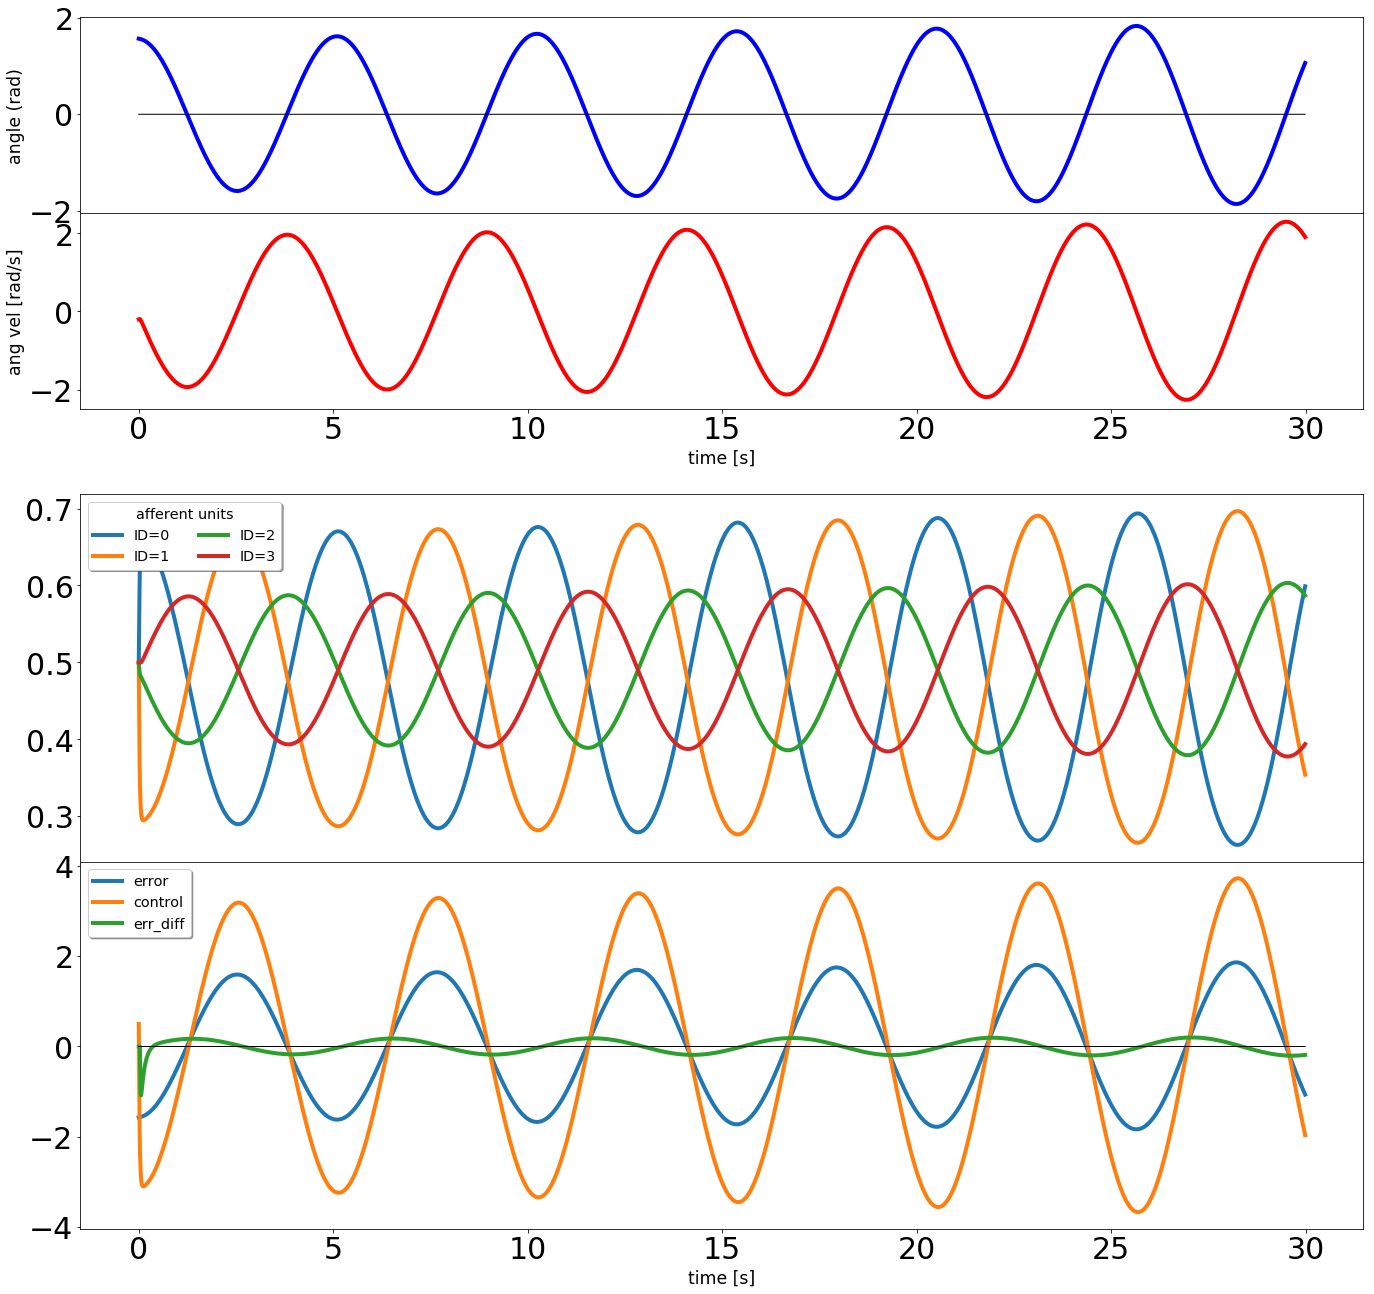

In [9]:
""" Simulate using no IC learning """
icc = ic_control()
icc.affs2ic_syn_spec['lrate'] = 0. # the learning rate of the inputs using the input correlation rule
icc.initialize()
icc.simulate(30.,flat=False)
icc.plot_results()

## SIMULATION 2

Execution time: 1.7781789302825928 seconds


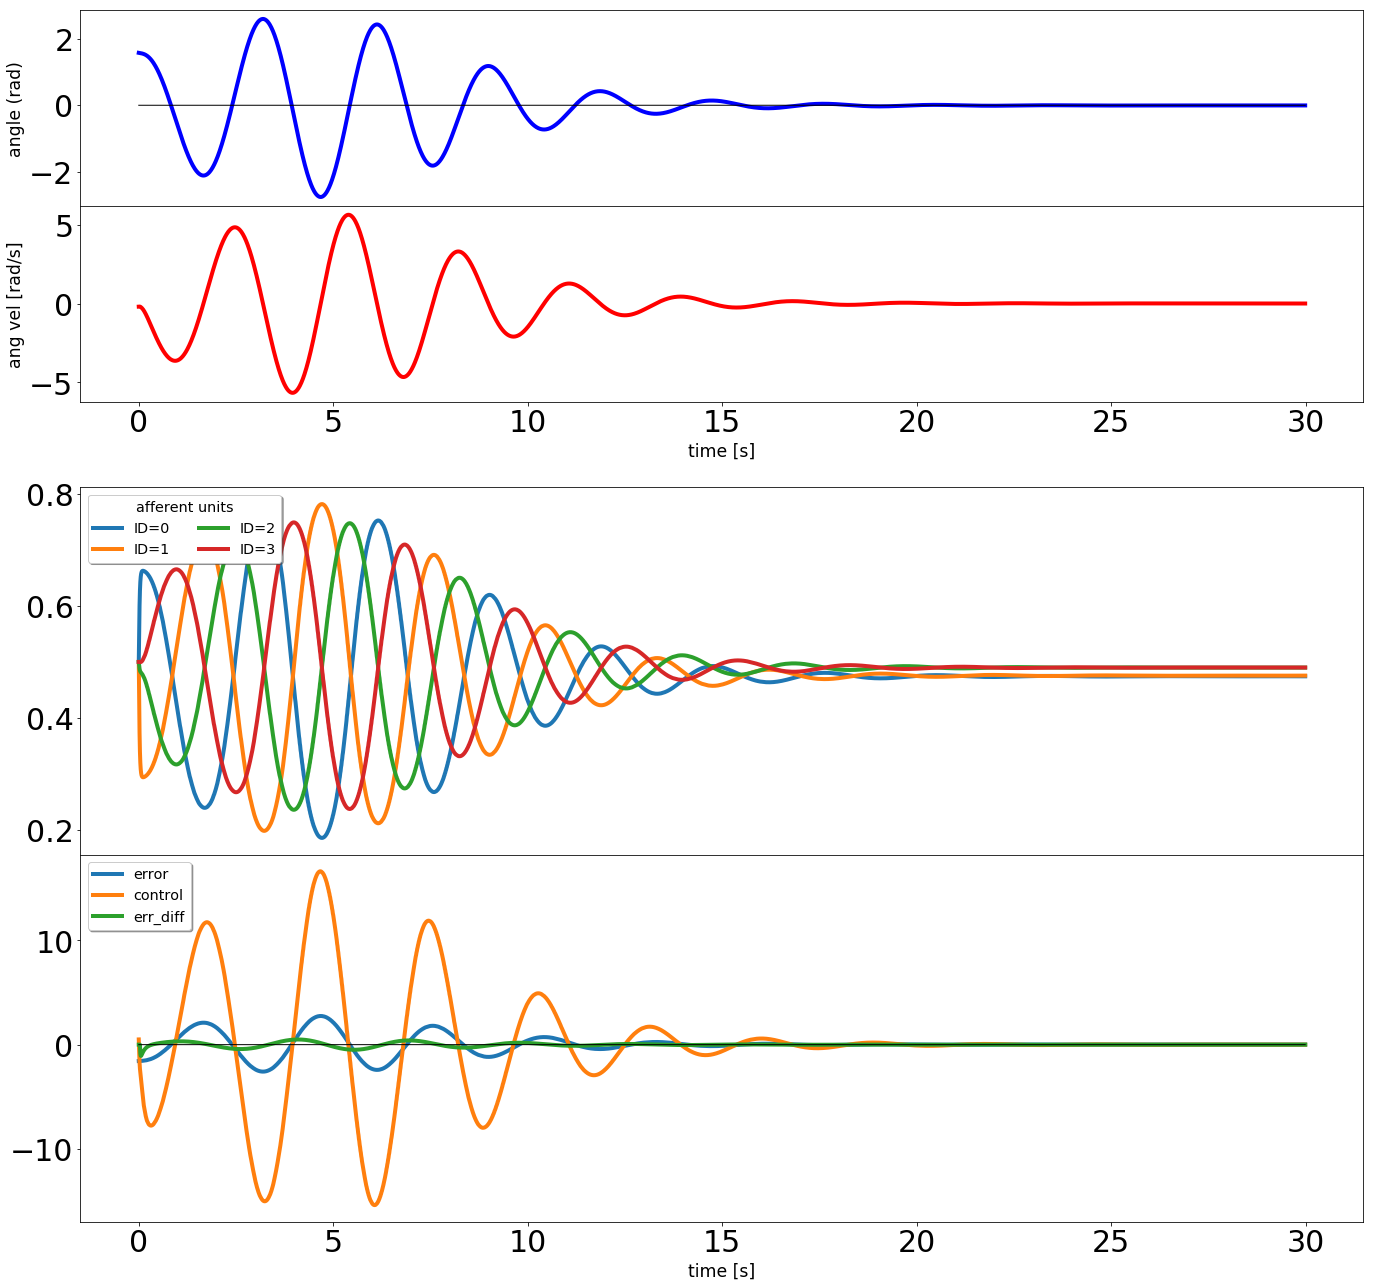

In [10]:
""" Simulate using IC learning """
icc = ic_control()
icc.affs2ic_syn_spec['lrate'] = 40. # the learning rate of the inputs using the input correlation rule
icc.initialize()
icc.simulate(30.,flat=True)
icc.plot_results()

As in the previous tutorial, the `flat` argument of the `simulate` function indicates whether to use `flat_run` for the simulation.

If you run this simulation with `flat = True`, there will be a warning message that some units will now use the forward Euler integration method. This does not apply to the pendulum, which is integrated with the `solve_ivp` method from Scipy even when the network is flat.

### Exploration 1
Changing various parameters can bring different results.

* Change the value of the desired angle, which is the `des_ang` attribute of the ic_control class, to a new value, such as $\pi/2$. 
* Change the initial angle of the pendulum, which is the `init_ang` entry in the `plant_params` dictionary.
* Include some gravity in the simulation by changing the `g` value in the `plant_params` dictionary.


### Exploration 2
One reason to use Draculab is to explore the effect of transmission delays.  
Suppose that the control unit takes 150 milliseconds to respond, instead of 20. This is roughly the time that it takes for an afferent signal to propagate to the cortex, produce a reaction, and propagate back to the muscle. This can be modeled by changing the corresponding connection specification in `ic_control.__init__`:  
`self.ic2pend_conn_spec = {'inp_ports' : [0], 'delays' : 0.15}`

Perform this change and run the two simulations again.  
What happens if the delay is 200 milliseconds?